In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
#from qiskit.tools.jupyter import *
#from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit import QuantumRegister, Qubit, Gate, ClassicalRegister
from qiskit.aqua.components.oracles import Oracle, TruthTableOracle
from qiskit.quantum_info import Statevector

# Transpiling things
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler.passes import BasicSwap, LookaheadSwap, StochasticSwap
from qiskit.transpiler import CouplingMap, Layout


#import utils
from collections import OrderedDict

import math
import numpy as np
from sympy.combinatorics.graycode import GrayCode, bin_to_gray, gray_to_bin

# Import general libraries (needed for functions)
import time

# Import Qiskit classes
import qiskit
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

from qiskit.test.mock import FakeYorktown #, FakeCasablanca

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
!pip install mitiq
import mitiq

  Using cached mitiq-0.2.0-py3-none-any.whl (61 kB)
  Using cached cirq_unstable-0.9.0.dev20200813185757-py3-none-any.whl (1.5 MB)
  Using cached numpy-1.18.5-cp37-cp37m-manylinux1_x86_64.whl (20.1 MB)
  Using cached google_api_core-1.23.0-py2.py3-none-any.whl (91 kB)
  Using cached protobuf-3.12.4-cp37-cp37m-manylinux1_x86_64.whl (1.3 MB)
  Using cached freezegun-0.3.15-py2.py3-none-any.whl (14 kB)
  Using cached google_auth-1.22.1-py2.py3-none-any.whl (114 kB)
  Using cached googleapis_common_protos-1.52.0-py2.py3-none-any.whl (100 kB)
  Using cached grpcio-1.33.1-cp37-cp37m-manylinux2014_x86_64.whl (3.8 MB)
  Using cached cachetools-4.1.1-py3-none-any.whl (10 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.6-py3-none-any.whl (47 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.11.4
    Uninstalling protobuf-3.11.4:
      Successfully uninstalled protobu

In [3]:
number_W = 2
beta = 1

coupling = [[0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 3], [2, 4], [3, 2], [3, 4], [4, 2], [4, 3]]

provider = IBMQ.get_provider(hub='ibm-q-research', group='Pablo-Antonio-Mo', project='main') 
print(provider)
backends = provider.backends()
for backend in backends:
    print(backend.name())
    
#backend = provider.backends(name = 'ibmqx2')[0]
backend = FakeYorktown()

<AccountProvider for IBMQ(hub='ibm-q-research', group='Pablo-Antonio-Mo', project='main')>
ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_vigo
ibmq_ourense
ibmq_valencia
ibmq_armonk
ibmq_athens
ibmq_rome
ibmq_santiago
ibmq_bogota
ibmq_casablanca


In [4]:
import json
with open('delta_energies_glycylglycine_1_random.json') as json_file:
    data = json.load(json_file)

deltas_dictionary = data['deltas']
deltas_dictionary = OrderedDict(sorted(deltas_dictionary.items()))
print(len(deltas_dictionary))
deltas = {}
for (key,value) in deltas_dictionary.items():
    deltas[key[:3]] = value
    #print(key,value)
print('corrected ------------------')
for (key,value) in deltas.items():
    print(key, value)

16
corrected ------------------
000 -0.7599604162252263
001 -0.43577938756914136
010 -0.491037486578648
011 0.43577938756914136
100 0.7599604162252263
101 -0.1668564579225631
110 0.491037486578648
111 0.1668564579225631


In [5]:
# Bitmap calculation
def calculate_angles(deltas_dictionary, beta = 1, scaling_factor = 1000):
    
    exact_angles = {}

    for key in deltas_dictionary.keys():

        if deltas_dictionary[key] >= 0:

            if scaling_factor == -1:
                probability = math.exp(-beta * deltas_dictionary[key])
            else:
                probability = math.exp(-scaling_factor* beta * deltas_dictionary[key])
        else: 
            probability = 1
        # Instead of encoding the angle corresponding to the probability, we will encode the angle theta such that sin^2(pi/2 - theta) = probability.
        # That way 1 -> 000, but if probability is 0 there is some small probability of acceptance

        # Instead of probability save angles so rotations are easier to perform afterwards sqrt(p) = sin(pi/2-theta/2).
        # The theta/2 is because if you input theta, qiskits rotates theta/2. Also normalised (divided between pi the result)
        exact_angles[key] = math.pi - 2 * math.asin(math.sqrt(probability))


    # Order angles by key
    exact_angles = OrderedDict(sorted(exact_angles.items()))

    return exact_angles

Let us have some error correction in place

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067219 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067420 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067272 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

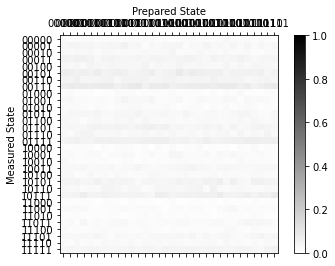

In [6]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(5)
qubit_list = range(5)
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

def insert_spaces(string):
    new_str = string[0]
    for item in string[1:-1]:
        new_str += ' '+ item
    new_str += ' ' + string[-1]
    return new_str

job = qiskit.execute(meas_calibs, backend=backend, shots=1024)
cal_results = job.result()

# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

Let us first construct the substitute of the oracle

In [7]:
angles = calculate_angles(deltas_dictionary = deltas, beta = 1, scaling_factor = 1)
print(angles)

def new_coin_flip(circuit,coin,move_id,angle_psi,angle_phi,angles,inverse):
    ''' Applies the controlled rotation to the target coin. Substitutes the oracle'''
    if inverse == 1:
        circuit.x(coin)
    
    if angles['111'] > .1:
        circuit.mcrx(theta = -inverse * angles['111'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(move_id)
    
    if angles['110'] > .1:
        circuit.mcrx(theta = -inverse * angles['110'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_psi)
    
    if angles['100'] > .1:
        circuit.mcrx(theta = -inverse * angles['100'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(move_id)
    
    if angles['101'] > .1:
        circuit.mcrx(theta = -inverse * angles['101'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_phi)
    
    if angles['001'] > .1:
        circuit.mcrx(theta = -inverse * angles['001'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(move_id)
    
    if angles['000'] > .1:
        circuit.mcrx(theta = -inverse * angles['000'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_psi)
    
    if angles['010'] > .1:
        circuit.mcrx(theta = -inverse * angles['010'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(move_id)
    
    if angles['011'] > .1:
        circuit.mcrx(theta = -inverse * angles['011'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False) 
    circuit.x(angle_phi)
    
    if inverse == -1:
        circuit.x(coin)

OrderedDict([('000', 0.0), ('001', 0.0), ('010', 0.0), ('011', 1.2728885468441173), ('100', 1.6354715267243518), ('101', 0.0), ('110', 1.3448976833778248), ('111', 0.8056505242148093)])


In [8]:
angles = calculate_angles(deltas_dictionary = deltas, beta = beta, scaling_factor = 1)
print(angles)
def map_dependent_coin_flip(circuit,ancilla,coin,move_id,angle_psi,angle_phi,angles,inverse):
    """
    Warning: This coin flip is dependent on the angles that are different from 0!
    We can use the ancilla in the same way it is used in the QROM iterator
    from the "Babbush et al. Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity", 
    figure 6
    """
    # First we should accept with probability 1
    circuit.x(coin)
    
    # The first swap
    # circuit.cswap(move_id, angle_psi, angle_phi)
    
    # From now we use psi and move_id only
    circuit.ccx(angle_psi, move_id, ancilla)
    #'''
    circuit.cu3(-inverse*angles['011'],-math.pi/2,math.pi/2,ancilla,coin)
    circuit.mcrx(-inverse*(angles['111']-angles['011']), [angle_phi[0], ancilla[0]], coin[0])
    '''
    circuit.x(angle_phi)
    circuit.mcrx(-inverse*angles['011'],[angle_phi[0], ancilla[0]], coin[0])
    circuit.x(angle_phi)
    circuit.mcrx(-inverse*angles['111'], [angle_phi[0], ancilla[0]], coin[0])
    #'''

    
    #One combines the ccx undoing the ancilla with the following one resulting in
    # circuit.ccx(angle_psi,move_id,ancilla)
    circuit.cx(angle_psi, ancilla)
    # circuit.ccx(angle_psi, ¬ move_id, ancilla)
    circuit.mcrx(-inverse*(angles['110']), [angle_phi[0], ancilla[0]], coin[0])
    
    #Same trick, this time we have to control on move_id being on state 0
    # circuit.ccx(angle_psi, ¬ move_id, ancilla)
    circuit.x(move_id)
    circuit.cx(move_id, ancilla)
    circuit.x(move_id)
    # circuit.ccx(¬ angle_psi, ¬ move_id, ancilla)
    
    circuit.mcrx(-inverse*angles['100'], [angle_phi[0], ancilla[0]], coin[0])
    
    #Controlling on angle_psi being on state 0
    # circuit.ccx(¬ angle_psi, ¬ move_id, ancilla)
    circuit.x(angle_psi)
    circuit.x(move_id)
    circuit.ccx(angle_psi, move_id, ancilla)
    circuit.x(angle_psi)
    circuit.x(move_id)
    '''
    circuit.x(angle_psi)
    circuit.cx(angle_psi, ancilla)
    circuit.x(angle_psi)
    # circuit.cxx(¬ angle_psi,  move_id, ancilla)
    
    #circuit.mcrx(-inverse*angles['011'], [angle_phi[0], ancilla[0]], coin[0]) Redundant
    
    # Finally uncompute the ancilla, circuit.cxx(¬ angle_psi,  move_id, ancilla)
    circuit.x(angle_psi)
    circuit.ccx(angle_psi,move_id,ancilla)
    circuit.x(angle_psi)
    '''
    # And final swap to get things back to where it belongs
    # circuit.cswap(move_id, angle_psi, angle_phi)

OrderedDict([('000', 0.0), ('001', 0.0), ('010', 0.0), ('011', 1.2728885468441173), ('100', 1.6354715267243518), ('101', 0.0), ('110', 1.3448976833778248), ('111', 0.8056505242148093)])


In [9]:
def arbitrary_map_dependent_coin_flip(circuit,ancilla,coin,move_id,angle_psi,angle_phi,angles,inv,iteration):
    # First we have to identify the non-zero angles. For the rest we accept with probability 1
    circuit.x(coin)
    
    non_zero_angles = dict(filter(lambda item: item[1]>.01, angles.items()))
    
    print(non_zero_angles)
    
    # Let us create 4 bins
    bins = OrderedDict() 
    
    for i in GrayCode(2).generate_gray():
        bins[i] = []
    for key in non_zero_angles.keys():
        bins[np.binary_repr(int(key[:2],2),width = 2)] += [key]
    
    print(bins)
    
    # To try to save some gates we arrange the iterator so that the first item is inactive
    start = '00'
    num_inactive = 0
    for k in reversed(bins.keys()):
        if bins[k] == []:
            start = np.binary_repr(int(k[:2],2)) # Notice that start is encoded in gray at this point
            num_inactive += 1

    # Calculate the length of the iteration
    if num_inactive == 0:
        length = 4
    elif num_inactive ==2 and (bins[bin_to_gray((i +1) % 4)] == []):
        length = 2
    else:
        length = 3
        
    print('lenght = ',length)

    def dif_bit(b_0, previous_b_0):
        for i in range(len(b)):
            if b_0[i] == previous_b_0[i]:
                print('The bit that is the same is ',i)
                return i
        return None

    # Let us now start with the iterator
    s = int(gray_to_bin(start))
    previous_b_0 = None
    
    for i in range(length):
        
        b = bins[bin_to_gray(np.binary_repr((i + s + 1) % 4, width = 2))]     # The structure of b is eg ['000','001']
        print('We are now in bin',b, 'previous_b_0',previous_b_0,'------------------------------')
        # First prepare the ancilla
        
        print('Computing the ancilla -------------------')
        
        if previous_b_0 is None: # This is if it is the first item in the iteration
            
            if b[0][0] == '0':
                print('circuit.x(angle_phi)')
                circuit.x(angle_phi)
            if b[0][1] == '0':
                print('circuit.x(angle_psi)')
                circuit.x(angle_psi)
            print('circuit.ccx(angle_phi,angle_psi,ancilla)')
            circuit.ccx(angle_phi,angle_psi,ancilla)
            
            if b[0][0] == '0':
                print('circuit.x(angle_phi)')
                circuit.x(angle_phi)
            if b[0][1] == '0':
                print('circuit.x(angle_psi)')
                circuit.x(angle_psi)
                
        elif dif_bit(b[0][:-1],previous_b_0[:-1]) == 0: # If the difference from the previous step is in position 0
            # We have to control on the bit that they have in common
            if previous_b_0[:-1][0] == 0:
                circuit.x(angle_phi)
                print('circuit.x(angle_phi')

            print('circuit.cx(angle_phi,ancilla)')
            circuit.cx(angle_phi,ancilla)
            
            if previous_b_0[:-1][0] == 0:
                circuit.x(angle_phi)
                print('circuit.x(angle_phi')
                
        elif dif_bit(b[0][:-1],previous_b_0[:-1]) == 1: # If the difference from the previous step is in position 1
            if previous_b_0[:-1][1] == 0:
                circuit.x(angle_psi)
                print('circuit.x(angle_psi')            
            
            print('circuit.cx(angle_psi,ancilla)')
            circuit.cx(angle_psi,ancilla)
            
            if previous_b_0[:-1][1] == 0:
                circuit.x(angle_psi)
                print('circuit.x(angle_psi')   
            
        
        print('Computing the main rotation -----------------------------')
        if len(b) == 1:
            if int(b[0][2]) == 0: # If we are controlling on move_id == 0
                circuit.x(move_id)
                print('circuit.x(move_id)')
            circuit.mcrx(theta = -inv*non_zero_angles[b[0]],q_controls = [move_id[0],ancilla[0]], q_target = coin[0], use_basis_gates=True)
            print('circuit.mcrx(theta = -inv*',non_zero_angles[b[0]],',q_controls = [move_id[0],ancilla[0]], q_target = coin[0], use_basis_gates=True)')
            if int(b[0][2]) == 0:
                print('circuit.x(move_id)')
                circuit.x(move_id)
                
        elif len(b) == 2:
            string = b[0][:-1]
            print('circuit.cu3( -inv*',non_zero_angles[string + '0'],'-math.pi/2,math.pi/2,ancilla,coin)')
            circuit.cu3( -inv*non_zero_angles[string + '0'],-math.pi/2,math.pi/2,ancilla,coin)
            print('circuit.mcrx(theta =-inv*(',non_zero_angles[string + '1'],'-',non_zero_angles[string + '0'],'), q_controls =[move_id[0], ancilla[0]], q_target = coin[0], use_basis_gates=True)')
            circuit.mcrx(theta =-inv*(non_zero_angles[string + '1']-non_zero_angles[string + '0']), q_controls =[move_id[0], ancilla[0]], q_target = coin[0], use_basis_gates=True)
    
        previous_b_0 = b[0]
    
    # Finally in the last step uncompute the ancilla, except in the last iteration == 1
    if iteration == 0:
        print('In the last step uncompute the uncilla -------------------')
        if previous_b_0[0] == '0':
            circuit.x(angle_phi)
            print('circuit.x(angle_phi)')
        if previous_b_0[1] == '0':
            circuit.x(angle_psi) 
            print('circuit.x(angle_psi)')

        circuit.ccx(angle_phi,angle_psi,ancilla)
        print('circuit.ccx(angle_phi,angle_psi,ancilla)')

        if previous_b_0[0] == '0':
            circuit.x(angle_phi)
            print('circuit.x(angle_phi)')
        if previous_b_0[1] == '0':
            circuit.x(angle_psi) 
            print('circuit.x(angle_psi)')

The quantum Walk is composed of several parts, $$W = R V^\dagger B^\dagger F B V,$$
where $V$ prepares possible moves, $B$ is the Boltzmann coin, $F$ the coin flip, and $R$ a reflection of all registers except the state one over state $\ket{0}$. The first thing we do is prepare the oracle


In [11]:
def W_step(qc,ancilla,coin,move_id,angle_psi,angle_phi,angles,iteration): 
    # Perform the preparation of possible moves----
    qc.h(move_id)

    # Prepare the Boltzmann coin ------------------
    #new_coin_flip(qc,coin,move_id,angle_psi,angle_phi,angles,inverse = 1)
    #map_dependent_coin_flip(qc,ancilla,coin,move_id,angle_psi,angle_phi,angles,1)
    arbitrary_map_dependent_coin_flip(qc,ancilla,coin,move_id,angle_psi,angle_phi,angles,inv = 1,iteration=0)
    
    # Perform move ---------------------------------
    # For the second angle
    qc.ccx(coin,move_id,angle_psi)

    # For the first angle
    qc.x(move_id)
    qc.ccx(coin,move_id,angle_phi)
    qc.x(move_id)

    if iteration == 0:
        # Unprepare the Boltzmann coin--------------------
        #new_coin_flip(qc,coin,move_id,angle_psi,angle_phi,angles,inverse = -1)
        #map_dependent_coin_flip(qc,ancilla,coin,move_id,angle_psi,angle_phi,angles,-1)
        arbitrary_map_dependent_coin_flip(qc,ancilla,coin,move_id,angle_psi,angle_phi,angles,inv = -1,iteration=0)

        # Perform the preparation of possible moves ----
        qc.h(move_id)

        #Reflection -------------------------------------
        qc.x(move_id)
        qc.x(coin)

        # Perform a multicontrolled Z
        qc.cz(move_id,coin)

        qc.x(move_id)
        qc.x(coin)

Running the model on a backend

In [12]:
def exe(raw_counts = None, mitigated_counts  = None, beta = 1, attemps = 1):
    move_id  = QuantumRegister(1)
    angle_phi = QuantumRegister(1)
    angle_psi = QuantumRegister(1)
    coin = QuantumRegister(1)
    ancilla = QuantumRegister(1)
    c_reg = ClassicalRegister(5)
    qc = QuantumCircuit(ancilla,coin,move_id,angle_psi,angle_phi,c_reg)

    #Circuit ----------
    qc.h(angle_phi)
    qc.h(angle_psi)
    for i in range(number_W):
        W_step(qc,ancilla,coin,move_id,angle_psi,angle_phi,angles,i)

    # Measure
    qc.measure(range(5), range(5))

    # Transpiling -------
    pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])
    pm = PassManager(pass_)
    qc = pm.run(qc)

    coupling_map = CouplingMap(couplinglist=coupling)
    qc = transpile(qc, backend = backend, seed_transpiler=1, optimization_level=1, layout_method = 'dense')
    
    if backend == provider.backends(name = 'ibmqx2')[0]:
        bs = BasicSwap(coupling_map=coupling_map)
        pass_manager = PassManager(bs)
        qc = pass_manager.run(qc)

        ls = LookaheadSwap(coupling_map=coupling_map)
        pass_manager = PassManager(ls)
        qc = pass_manager.run(qc)

        ss = StochasticSwap(coupling_map=coupling_map)
        pass_manager = PassManager(ss)
        qc = pass_manager.run(qc)
        
    qc = transpile(qc, backend = backend, seed_transpiler=1, optimization_level=2)

    pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])
    pm = PassManager(pass_)
    qc = pm.run(qc)

    qc = transpile(qc, backend = backend, seed_transpiler=1, optimization_level=3)
    print('After optimization--------')
    print('gates = ', qc.count_ops())
    print('depth = ', qc.depth())

    job = execute(qc, backend, shots=8192)
    results = job.result()

    # Results without mitigation
    if raw_counts == None:
        raw_counts = results.get_counts()
    else:
        new_raw = results.get_counts()
        for key in raw_counts:
            raw_counts[key] += new_raw[key]


    # Get the filter object
    meas_filter = meas_fitter.filter

    # Results with mitigation
    mitigated_results = meas_filter.apply(results)
    if mitigated_counts == None:
        mitigated_counts = mitigated_results.get_counts()
    else:
        new_miti = mitigated_results.get_counts()
        for key in mitigated_counts:
            mitigated_counts[key] += new_miti[key]
            
    return raw_counts, mitigated_counts

raw_counts, mitigated_counts = exe(beta = beta)

{'011': 1.2728885468441173, '100': 1.6354715267243518, '110': 1.3448976833778248, '111': 0.8056505242148093}
OrderedDict([('00', []), ('01', ['011']), ('11', ['110', '111']), ('10', ['100'])])
lenght =  3
We are now in bin ['011'] previous_b_0 None ------------------------------
Computing the ancilla -------------------
circuit.x(angle_phi)
circuit.ccx(angle_phi,angle_psi,ancilla)
circuit.x(angle_phi)
Computing the main rotation -----------------------------
circuit.mcrx(theta = -inv* 1.2728885468441173 ,q_controls = [move_id[0],ancilla[0]], q_target = coin[0], use_basis_gates=True)
We are now in bin ['110', '111'] previous_b_0 011 ------------------------------
Computing the ancilla -------------------
The bit that is the same is  1
The bit that is the same is  1
circuit.cx(angle_psi,ancilla)
Computing the main rotation -----------------------------
circuit.cu3( -inv* 1.3448976833778248 -math.pi/2,math.pi/2,ancilla,coin)
circuit.mcrx(theta =-inv*( 0.8056505242148093 - 1.34489768337782

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067219 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067420 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067272 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

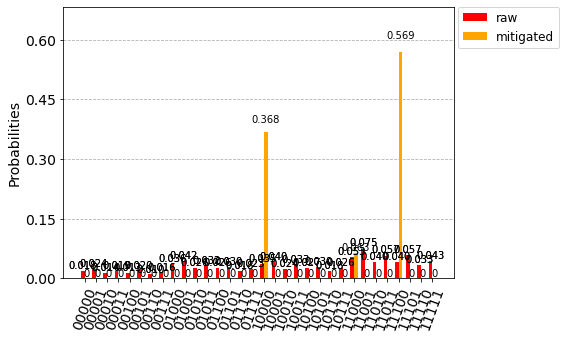

In [13]:
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'], color = ['red','orange'])

In [14]:
def calc_probabilities(counts):
    'Calculates the probabilities when measuring the first two qubits'
    new_counts = {}
    for i in ['00','01','10','11']:
        new_counts[i] = 0
    for item in counts:
        new_counts[item[0] + item[1]] += counts[item]
    return new_counts

Let us try some other kind of mitigation of error, using mitiq: https://mitiq.readthedocs.io/en/stable/guide/guide-ibmq-backends.html

In [ ]:
def backend_executor(circuit: QuantumCircuit, shots: int = 8192) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    # (1) Add measurements to the circuit
    #circuit.measure(circuit.qregs[0], circuit.cregs[0])

    # (2) Run the circuit
    job = qiskit.execute(
        experiments=circuit,
        backend=backend,
        optimization_level=0,  # Important!
        shots=shots
    )

    # (3) Convert from raw measurement counts to the expectation value
    counts = job.result().get_counts()
    print(counts)
    if counts.get("1 1") is None:
        expectation_value = 0.
    else:
        expectation_value = counts.get("1 1") / shots
    return expectation_value

# The circuit ------------------------------------------------------------------------------
def mitig()
move_id  = QuantumRegister(1)
angle_phi = QuantumRegister(1)
angle_psi = QuantumRegister(1)
coin = QuantumRegister(1)
ancilla = QuantumRegister(1)
c_reg = ClassicalRegister(5)
qc = QuantumCircuit(ancilla,coin,move_id,angle_psi,angle_phi,c_reg)

number_W = 2 # Parameter

#Circuit ----------
qc.h(angle_phi)
qc.h(angle_psi)
for i in range(number_W):
    W_step(qc,ancilla,coin,move_id,angle_psi,angle_phi,angles,i)

# Measure
qc.measure([3,4], [3,4])

# Transpiling -------
pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])
pm = PassManager(pass_)
qc = pm.run(qc)

coupling_map = CouplingMap(couplinglist=coupling)
qc = transpile(qc, backend = backend, seed_transpiler=1, optimization_level=1, layout_method = 'dense')

qc = transpile(qc, backend = backend, seed_transpiler=1, optimization_level=2)

if backend == provider.backends(name = 'ibmqx2')[0]:
    bs = BasicSwap(coupling_map=coupling_map)
    pass_manager = PassManager(bs)
    qc = pass_manager.run(qc)

    ls = LookaheadSwap(coupling_map=coupling_map)
    pass_manager = PassManager(ls)
    qc = pass_manager.run(qc)

    ss = StochasticSwap(coupling_map=coupling_map)
    pass_manager = PassManager(ss)
    qc = pass_manager.run(qc)

pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])
pm = PassManager(pass_)
qc = pm.run(qc)

qc = transpile(qc, backend = backend, seed_transpiler=1, optimization_level=3)
print('After optimization--------')
print('gates = ', qc.count_ops())
print('depth = ', qc.depth())

# Executing the mitigation ----------------------------------------------------------
miti= {}
miti['11'] = mitiq.execute_with_zne(qc, backend_executor)
miti['00'] = 0
miti['01'] = 0
miti['10'] = 0

The same circuit without error can be seen in

{'011': 1.2728885468441173, '100': 1.6354715267243518, '110': 1.3448976833778248, '111': 0.8056505242148093}
OrderedDict([('00', []), ('01', ['011']), ('11', ['110', '111']), ('10', ['100'])])
lenght =  3
We are now in bin ['011'] previous_b_0 None ------------------------------
Computing the ancilla -------------------
circuit.x(angle_phi)
circuit.ccx(angle_phi,angle_psi,ancilla)
circuit.x(angle_phi)
Computing the main rotation -----------------------------
circuit.mcrx(theta = -inv* 1.2728885468441173 ,q_controls = [move_id[0],ancilla[0]], q_target = coin[0], use_basis_gates=True)
We are now in bin ['110', '111'] previous_b_0 011 ------------------------------
Computing the ancilla -------------------
The bit that is the same is  1
The bit that is the same is  1
circuit.cx(angle_psi,ancilla)
Computing the main rotation -----------------------------
circuit.cu3( -inv* 1.3448976833778248 -math.pi/2,math.pi/2,ancilla,coin)
circuit.mcrx(theta =-inv*( 0.8056505242148093 - 1.34489768337782

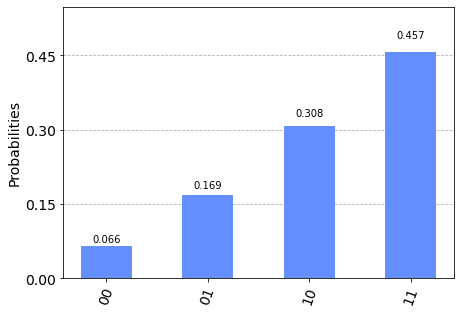

In [15]:
move_id  = QuantumRegister(1)
angle_phi = QuantumRegister(1)
angle_psi = QuantumRegister(1)
coin = QuantumRegister(1)
ancilla = QuantumRegister(1)
c_reg = ClassicalRegister(5)
aerqc = QuantumCircuit(ancilla,coin,move_id,angle_psi,angle_phi,c_reg)

#Circuit ----------
aerqc.h(angle_phi)
aerqc.h(angle_psi)
for i in range(number_W):
    W_step(aerqc,ancilla,coin,move_id,angle_psi,angle_phi,angles,i)
    
# Measure
aerbackend = Aer.get_backend('statevector_simulator')
backend_options = {"method" : "statevector"}
experiment = execute(aerqc, aerbackend, backend_options=backend_options)
state_vector = Statevector(experiment.result().get_statevector(aerqc))

probabilities = state_vector.probabilities([3,4])
noiseless_counts = {}
noiseless_counts['00'] = float(probabilities[0])
noiseless_counts['01'] = float(probabilities[1])
noiseless_counts['10'] = float(probabilities[2])
noiseless_counts['11'] = float(probabilities[3])

from qiskit.visualization import plot_histogram
plot_histogram(noiseless_counts)

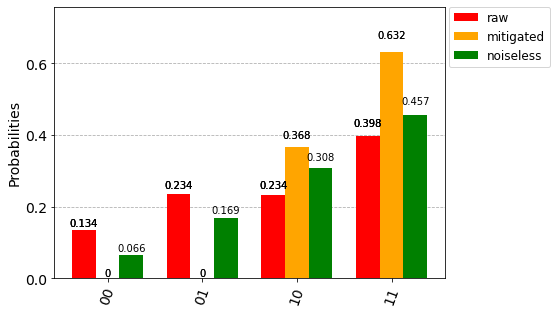

In [16]:
#plot_histogram([calc_probabilities(raw_counts), calc_probabilities(mitigated_counts),miti,noiseless_counts], legend=['raw', 'mitigated','mitiq','noiseless'], color = ['red','orange','yellow','green'])
plot_histogram([calc_probabilities(raw_counts), calc_probabilities(mitigated_counts),noiseless_counts], legend=['raw', 'mitigated','noiseless'], color = ['red','orange','green'])